In [6]:
%load_ext autoreload
%autoreload 2

import os
from dotenv import load_dotenv

load_dotenv()

import logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.getLogger('web_data_collection').setLevel(logging.DEBUG)

from web_data_collection import LLMConfig, generate_search_queries, retrieve_webpages, retrieve_webpages_streaming, BrightDataConfig, Reranker, generate_extraction_schema, extract_data, control_quality

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
openai_api_key = os.environ.get("OPENAI_API_KEY")
llm_config = LLMConfig(api_key=openai_api_key, model="openai/gpt-4.1", temperature=0.2)

bright_data_api_key = os.environ.get("BRIGHT_DATA_API_KEY")
bright_data_zone = os.environ.get("BRIGHT_DATA_ZONE")
bright_data_config = BrightDataConfig(api_key=bright_data_api_key, zone=bright_data_zone)

In [3]:
dataset_description = "Reports of download counts of COVID contact tracing apps in different U.S. states."
# variables = {"state_and_app_name": ["Alabama GuideSafe"]}
variables = {"state_and_app_name": ["Alabama GuideSafe", "Arizona Covid Watch", "California Covid Notify", "Colorado Exposure Notifications", "Connecticut Covid Alert"]}
variable_names = list(variables.keys())

# Search Query Generation

In [4]:
num_queries = 3

query_templates = generate_search_queries(dataset_description, num_queries, llm_config, variable_names)
for query_template in query_templates:
    print(query_template)

download count of {state_and_app_name} COVID contact tracing app
{state_and_app_name} COVID contact tracing app downloads
{state_and_app_name} COVID app number of downloads


# Web Page Retrieval

2025-07-09 13:33:59,530 - web_data_collection.webpage_retrieval - DEBUG - Expanded 3 templates into 15 queries
2025-07-09 13:33:59,531 - web_data_collection.webpage_retrieval - DEBUG - Processing query: download count of Alabama GuideSafe COVID contact tracing app, variable value combo: ('Alabama GuideSafe',)
2025-07-09 13:33:59,531 - web_data_collection.webpage_retrieval - DEBUG - Processing date chunk: None to None
2025-07-09 13:33:59,532 - web_data_collection.webpage_retrieval - DEBUG - Making request 1/1
2025-07-09 13:34:02,756 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'download count of Alabama GuideSafe COVID contact tracing app', 'results_cnt': 1320, 'search_time': 0.28, 'language': 'en-UY', 'country': 'Uruguay', 'country_code': 'UY', 'location': 'United States', 'gl': 'UY', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'download count of Alabama GuideSafe COVID contact tracing app - Google Sea

(('Alabama GuideSafe',), 'download count of Alabama GuideSafe COVID contact tracing app', {'link': 'https://www.guidesafe.org/exposure-notification-app/', 'title': "Alabama's Exposure Notification App", 'description': "Here's How Alabama's GuideSafe™ Exposure Notification App Works: ... Step one: Download the GuideSafe™ Exposure Notification App from the App Store or Google Play ..."})
(('Alabama GuideSafe',), 'download count of Alabama GuideSafe COVID contact tracing app', {'link': 'https://sites.uab.edu/guidesafebackup2/exposure-notification-app/', 'title': 'Exposure Notification App | GuideSafe™', 'description': 'Step one: Download the GuideSafe™️ Exposure Notification App from the App Store or Google Play, and then enabling Bluetooth. Step two: If you have tested ...'})
(('Alabama GuideSafe',), 'download count of Alabama GuideSafe COVID contact tracing app', {'link': 'https://www.guidesafe.org/', 'title': 'GuideSafe™ | The tools and resources to help fight COVID-19 ...', 'descripti

2025-07-09 13:34:05,038 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'download count of Arizona Covid Watch COVID contact tracing app', 'results_cnt': 106000, 'search_time': 0.53, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'download count of Arizona Covid Watch COVID contact tracing app - Google Search', 'timestamp': '2025-07-09T17:34:04.871Z'}, 'input': {'original_url': 'https://www.google.com/search?q=download+count+of+Arizona+Covid+Watch+COVID+contact+tracing+app&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_aqi425gs34r'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=download+count+of+Arizona+Covid+Watch+COVID+contact+tracing+app&num=20&sca_esv=f7156635f6e9a261&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEreERTNAkkP8Y6EXltYTGWs9RGaEMfZ2dZFFrbmM-rnq9t2Yd6CLmSU0fTw2YpsUFAZkjtkV3nlJNkF6dgnv8hBP

(('Arizona Covid Watch',), 'download count of Arizona Covid Watch COVID contact tracing app', {'link': 'https://news.arizona.edu/news/how-smartphone-app-and-contact-tracing-helped-keep-uarizona-open-and-curb-covid-19-spread#:~:text=The%20app%20then%20sends%20an,have%20downloaded%20the%20mobile%20app.', 'title': 'How a Smartphone App and Contact Tracing Helped Keep ...', 'description': ''})
(('Arizona Covid Watch',), 'download count of Arizona Covid Watch COVID contact tracing app', {'link': 'https://wehealth.org/covidwatchorg/news', 'title': 'News and Media | Covid Watch', 'description': 'UArizona is launching a new mobile app that lets students know anonymously if they have been exposed to COVID-19. August 19, 2020.'})
(('Arizona Covid Watch',), 'download count of Arizona Covid Watch COVID contact tracing app', {'link': 'https://edscoop.com/university-arizona-contact-tracing-reduced-covid19-12-percent/', 'title': 'U. Arizona claims contact-tracing app reduced COVID-19 ...', 'descripti

2025-07-09 13:34:07,703 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'download count of California Covid Notify COVID contact tracing app', 'results_cnt': 6890000, 'search_time': 0.38, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'download count of California Covid Notify COVID contact tracing app - Google Search', 'timestamp': '2025-07-09T17:34:07.347Z'}, 'input': {'original_url': 'https://www.google.com/search?q=download+count+of+California+Covid+Notify+COVID+contact+tracing+app&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_x6jb62gpg5'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=download+count+of+California+Covid+Notify+COVID+contact+tracing+app&num=20&sca_esv=f7156635f6e9a261&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEreERTNAkkP8Y6EXltYTGWs9RGaEMfZ2dZFFrbmM-rnq9t2Yd6CLmSU0fTw2YpsUFAZkjtkV

(('California Covid Notify',), 'download count of California Covid Notify COVID contact tracing app', {'link': 'https://pmc.ncbi.nlm.nih.gov/articles/PMC9678789/', 'title': 'Defining Key Performance Indicators for the California ...', 'description': 'California deployed the Google Apple Exposure Notification framework, branded CA Notify, on December 10, 2020, to supplement traditional COVID-19 contact ...'})
(('California Covid Notify',), 'download count of California Covid Notify COVID contact tracing app', {'link': 'https://www.fhcsd.org/ca-notify/', 'title': 'CA Notify | COVID-19 Exposure Notifications', 'description': 'CA Notify is a phone application that will inform Californians if they have been exposed to someone who has tested positive for COVID-19.'})
(('California Covid Notify',), 'download count of California Covid Notify COVID contact tracing app', {'link': 'https://www.cdph.ca.gov/Programs/CID/DCDC/Pages/CANotify/CANotifyMain.aspx', 'title': 'CA Notify Home - CDPH - CA.go

2025-07-09 13:34:10,158 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'download count of Colorado Exposure Notifications COVID contact tracing app', 'results_cnt': 88600, 'search_time': 0.31, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'download count of Colorado Exposure Notifications COVID contact tracing app - Google Search', 'timestamp': '2025-07-09T17:34:09.935Z'}, 'input': {'original_url': 'https://www.google.com/search?q=download+count+of+Colorado+Exposure+Notifications+COVID+contact+tracing+app&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_fz2f2xmkdpw'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=download+count+of+Colorado+Exposure+Notifications+COVID+contact+tracing+app&num=20&sca_esv=73a6d3bdeda9064e&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEiTm5uW1q0uNfK7KsnoL8hUyUYUJLZ_b-p0lT09DI

(('Colorado Exposure Notifications',), 'download count of Colorado Exposure Notifications COVID contact tracing app', {'link': 'https://coloradosun.com/2023/05/08/colorado-exposure-notifications-phone-app/', 'title': 'Colorado is ending its Exposure Notifications phone app ...', 'description': 'The service is ending in Colorado on Thursday, according to the state Department of Public Health and Environment.'})
(('Colorado Exposure Notifications',), 'download count of Colorado Exposure Notifications COVID contact tracing app', {'link': 'https://www.9news.com/article/news/local/next/colorado-covid-tracing-app-2020-december-coronavirus/73-1c4bf0ce-6c26-4323-9eda-ce31b8f11639', 'title': 'Tons of Coloradans got the COVID exposure tracking app', 'description': 'More than 1.4 million people in the state have the COVID-19 exposure app on their phones, but much fewer people are using it.'})
(('Colorado Exposure Notifications',), 'download count of Colorado Exposure Notifications COVID contact t

2025-07-09 13:34:13,053 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'download count of Connecticut Covid Alert COVID contact tracing app', 'results_cnt': 365000, 'search_time': 0.54, 'language': 'en-CO', 'country': 'Colombia', 'country_code': 'CO', 'location': 'United States', 'gl': 'CO', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'download count of Connecticut Covid Alert COVID contact tracing app - Google Search', 'timestamp': '2025-07-09T17:34:12.842Z'}, 'input': {'original_url': 'https://www.google.com/search?q=download+count+of+Connecticut+Covid+Alert+COVID+contact+tracing+app&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_an83h5qzckp'}, 'navigation': [{'title': 'News', 'href': 'https://www.google.com/search?num=20&sca_esv=73a6d3bdeda9064e&hl=en&q=download+count+of+Connecticut+Covid+Alert+COVID+contact+tracing+app&tbm=nws&source=lnms&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEi

(('Connecticut Covid Alert',), 'download count of Connecticut Covid Alert COVID contact tracing app', {'link': 'https://catalog.data.gov/dataset/covid-19-contact-tracing-covid-alert-ct-summary-by-week', 'title': 'COVID-19 Contact Tracing: COVID Alert CT Summary by Week', 'description': 'If downloaded, the app will alert users if they have come into close contact with somebody who tests positive for COVID-19. This dataset includes the cumulative ...'})
(('Connecticut Covid Alert',), 'download count of Connecticut Covid Alert COVID contact tracing app', {'link': 'https://data.ct.gov/Health-and-Human-Services/COVID-19-Contact-Tracing-COVID-Alert-CT-Summary-by/c4dk-8f27', 'title': 'COVID Alert CT Summary by Week - ARCHIVE | Connecticut ...', 'description': '... COVID-19 Contact Tracing: COVID Alert CT Summary by Week - ARCHIVE. Health and Human Services. Note: This dataset has been archived and is no longer being ...'})
(('Connecticut Covid Alert',), 'download count of Connecticut Covid Al

2025-07-09 13:34:14,671 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Alabama GuideSafe COVID contact tracing app downloads', 'results_cnt': 643, 'search_time': 0.28, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Alabama GuideSafe COVID contact tracing app downloads - Google Search', 'timestamp': '2025-07-09T17:34:14.526Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Alabama+GuideSafe+COVID+contact+tracing+app+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_v9s6hbsvcha'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=Alabama+GuideSafe+COVID+contact+tracing+app+downloads&num=20&sca_esv=73a6d3bdeda9064e&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEreERTNAkkP8Y6EXltYTGWs9RGaEMfZ2dZFFrbmM-rnqDh6hIMjQfCAhrLJz0ZmMZpUjCqTWcnwxm3CIjs0GarosQfLkZI74FJnvDMIm-XrwYNH_ZLlnLC3tycVbHgi9_Y2
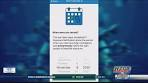
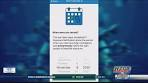

(('Alabama GuideSafe',), 'Alabama GuideSafe COVID contact tracing app downloads', {'link': 'https://www.guidesafe.org/exposure-notification-app/#:~:text=Step%20one%3A%20Download%20the%20GuideSafe,can%20choose%20to%20report%20it.', 'title': "Alabama's Exposure Notification App - GuideSafe", 'description': ''})
(('Alabama GuideSafe',), 'Alabama GuideSafe COVID contact tracing app downloads', {'link': 'https://x.com/guidesafe_org', 'title': 'GuideSafe™ (@guidesafe_org) / X', 'description': 'Help stop the spread of COVID-19 in Alabama by downloading the app today. ... \u2069 and other COVID contact tracing apps https://washingtonpost.com/technology ...'})
(('Alabama GuideSafe',), 'Alabama GuideSafe COVID contact tracing app downloads', {'link': 'https://abc3340.com/news/local/alabama-college-students-encouraged-to-download-covid-19-contact-tracing-app-08-11-2020', 'title': 'Alabama college students encouraged to download COVID ...', 'description': "The app will use Bluetooth technology to 

2025-07-09 13:34:16,406 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Arizona Covid Watch COVID contact tracing app downloads', 'results_cnt': 237000, 'search_time': 0.42, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Arizona Covid Watch COVID contact tracing app downloads - Google Search', 'timestamp': '2025-07-09T17:34:16.061Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Arizona+Covid+Watch+COVID+contact+tracing+app+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_muw6ve4owza'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=Arizona+Covid+Watch+COVID+contact+tracing+app+downloads&num=20&sca_esv=f7156635f6e9a261&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEreERTNAkkP8Y6EXltYTGWs9RGaEMfZ2dZFFrbmM-rnq9t2Yd6CLmSU0fTw2YpsUFAZkjtkV3nlJNkF6dgnv8hBPbkvFBFvt9qVz5tXWHwMIOLAC51x133zp
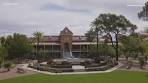
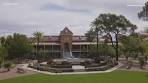

(('Arizona Covid Watch',), 'Arizona Covid Watch COVID contact tracing app downloads', {'link': 'https://news.arizona.edu/news/how-smartphone-app-and-contact-tracing-helped-keep-uarizona-open-and-curb-covid-19-spread', 'title': 'How a Smartphone App and Contact Tracing Helped Keep ...', 'description': 'The app is designed to anonymously alert users of exposure to COVID-19 and direct them to appropriate resources. Anyone can download the app, ...'})
(('Arizona Covid Watch',), 'Arizona Covid Watch COVID contact tracing app downloads', {'link': 'https://www.facebook.com/CovidWatchOrg/', 'title': 'Covid Watch', 'description': '*** Download Covid Watch Arizona, now available in App Store and Google Play: https://www.covidwatch.org/app/us-az/ios https://www.covidwatch.org/app/us-az/ ...'})
(('Arizona Covid Watch',), 'Arizona Covid Watch COVID contact tracing app downloads', {'link': 'https://www.youtube.com/watch?v=ZEBlsVYEbtM', 'title': 'The University of Arizona launches contact tracing app

2025-07-09 13:34:18,557 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'California Covid Notify COVID contact tracing app downloads', 'results_cnt': 12600000, 'search_time': 0.5, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'California Covid Notify COVID contact tracing app downloads - Google Search', 'timestamp': '2025-07-09T17:34:18.222Z'}, 'input': {'original_url': 'https://www.google.com/search?q=California+Covid+Notify+COVID+contact+tracing+app+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_n24n152l7a'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=California+Covid+Notify+COVID+contact+tracing+app+downloads&num=20&sca_esv=f7156635f6e9a261&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEiL7FsMqPMz12BdbDgJD8Lorzd08GGKixt6OKyOWF8StX6T57k0hxdMtM51Dl614VyYVGWeT4vV8EUZyX0xXOdJ2DOONh45WHzq7Vj2_

(('California Covid Notify',), 'California Covid Notify COVID contact tracing app downloads', {'link': 'http://www.alamedahealthsystem.org/californias-covid-19-exposure-notification-app-is-now-live/', 'title': "California's COVID-19 Exposure Notification App Is Now Live", 'description': 'Smartphone users can sign up for CA Notify, an app that sends an alert if the user has been around someone who later tests positive for COVID-19 ...'})
(('California Covid Notify',), 'California Covid Notify COVID contact tracing app downloads', {'link': 'https://www.sacbee.com/news/california/article257189242.html', 'title': 'Remember COVID-19 phone alerts? California app ...', 'description': 'The CA Notify app has been downloaded more than 15.6 million times since Gov. ... contact tracing app is much more widely promoted.'})
(('California Covid Notify',), 'California Covid Notify COVID contact tracing app downloads', {'link': 'https://news.berkeley.edu/2020/11/16/uc-berkeley-launches-covid-19-exposur

2025-07-09 13:34:21,219 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Colorado Exposure Notifications COVID contact tracing app downloads', 'results_cnt': 194000, 'search_time': 0.44, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Colorado Exposure Notifications COVID contact tracing app downloads - Google Search', 'timestamp': '2025-07-09T17:34:20.994Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Colorado+Exposure+Notifications+COVID+contact+tracing+app+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_btywds8bl4'}, 'navigation': [{'title': 'News', 'href': 'https://www.google.com/search?num=20&sca_esv=f7156635f6e9a261&hl=en&q=Colorado+Exposure+Notifications+COVID+contact+tracing+app+downloads&tbm=nws&source=lnms&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEreERTNAkkP8Y6EXltYTGWs9RGaEMfZ2dZFFrbmM-rnq9t2Yd6CLmSU0fTw2Yps

(('Colorado Exposure Notifications',), 'Colorado Exposure Notifications COVID contact tracing app downloads', {'link': 'https://www.cpr.org/2020/10/22/new-phone-app-to-track-colorado-coronavirus-exposure-will-arrive-this-weekend/', 'title': 'New Phone App To Track Colorado Coronavirus Exposure ...', 'description': 'The Exposure Notification System will be part of the settings on Apple iPhones and a downloadable app for Android users.'})
(('Colorado Exposure Notifications',), 'Colorado Exposure Notifications COVID contact tracing app downloads', {'link': 'https://coloradosun.com/2020/10/23/colorado-coronavirus-exposure-notification-app/', 'title': "A phone app that will tell you if you've been exposed to ...", 'description': "A phone app that will tell you if you've been exposed to coronavirus is about to launch in Colorado. Here's how to use it. The app, called ..."})
(('Colorado Exposure Notifications',), 'Colorado Exposure Notifications COVID contact tracing app downloads', {'link': 

2025-07-09 13:34:23,880 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Connecticut Covid Alert COVID contact tracing app downloads', 'results_cnt': 625000, 'search_time': 0.57, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Connecticut Covid Alert COVID contact tracing app downloads - Google Search', 'timestamp': '2025-07-09T17:34:23.718Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Connecticut+Covid+Alert+COVID+contact+tracing+app+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_lbqqb6spdn'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=Connecticut+Covid+Alert+COVID+contact+tracing+app+downloads&num=20&sca_esv=73a6d3bdeda9064e&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZPH5QghoXViUOqdFyhkUfHhA90f6RZnLvcDKUWyhDavFJHvqNnhR_vnElk0C8uWstBiWS01_8uLZPDmJZiTaH7zDUn3Be5K8OJ8m5LUL1m9P6k7UkWjI3XyPagENr0

(('Connecticut Covid Alert',), 'Connecticut Covid Alert COVID contact tracing app downloads', {'link': 'https://www.columbiact.gov/community/page/covid-alert-ct-app#:~:text=The%20free%20mobile%20app%E2%80%93available,the%20Settings%20app%20on%20iOS.', 'title': 'COVID Alert CT App - Columbia, CT', 'description': ''})
(('Connecticut Covid Alert',), 'Connecticut Covid Alert COVID contact tracing app downloads', {'link': 'https://www.apkmirror.com/apk/ct-department-of-public-health/covid-alert-ct/', 'title': 'Download COVID Alert CT APKs for Android', 'description': 'COVID Alert CT is the official COVID-19 exposure notification app in the State of Connecticut. It is supported by the Connecticut Department of Public ...'})
(('Connecticut Covid Alert',), 'Connecticut Covid Alert COVID contact tracing app downloads', {'link': 'https://www.nascio.org/awards-library/awards/contact-tracing-innovation-contact/', 'title': "ContaCT—Connecticut's Integrated COVID-19 ...", 'description': 'The applica

2025-07-09 13:34:25,315 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Alabama GuideSafe COVID app number of downloads', 'results_cnt': 691, 'search_time': 0.41, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Alabama GuideSafe COVID app number of downloads - Google Search', 'timestamp': '2025-07-09T17:34:25.018Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Alabama+GuideSafe+COVID+app+number+of+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_ac5397g66s'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=Alabama+GuideSafe+COVID+app+number+of+downloads&num=20&sca_esv=73a6d3bdeda9064e&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEiTm5uW1q0uNfK7KsnoL8hUyUYUJLZ_b-p0lT09DIkR7bwzZ58goNnPFwCobO9Lr1GqquLGz16X4CICKxqKCKUwzddVlh446Bq6KIcmINbfh8DJhqfU5q2zJkgVUVt_rBK8u5ucaQFBa07v5kJsGA7w7lghU

(('Alabama GuideSafe',), 'Alabama GuideSafe COVID app number of downloads', {'link': 'https://www.wbrc.com/2020/10/23/alabama-covid-exposure-app-grows-with-more-than-downloads/', 'title': 'Alabama COVID-19 exposure app grows with more than ...', 'description': "Alabama COVID-19 exposure app grows with more than 100,000 downloads ... The GuideSafe Exposure Notification app isn't just for college ..."})
(('Alabama GuideSafe',), 'Alabama GuideSafe COVID app number of downloads', {'link': 'https://www.wbrc.com/2020/09/18/guidesafe-supporters-want-more-downloads-covid-exposure-notification-app/', 'title': 'GuideSafe supporters want more downloads of COVID ...', 'description': 'School officials provided an update on the program Friday. So far, there have been 62,000 downloads of the Guidesafe app.'})
(('Alabama GuideSafe',), 'Alabama GuideSafe COVID app number of downloads', {'link': 'https://www.rocketcitynow.com/video/news/local/alabama-guidesafe-covid-19-app/525-973f3a54-d4f6-4c9e-aa29-f6

2025-07-09 13:34:27,737 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'Arizona Covid Watch COVID app number of downloads', 'results_cnt': 2190000, 'search_time': 0.56, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'Arizona Covid Watch COVID app number of downloads - Google Search', 'timestamp': '2025-07-09T17:34:27.537Z'}, 'input': {'original_url': 'https://www.google.com/search?q=Arizona+Covid+Watch+COVID+app+number+of+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_n8l06d0rkr'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=Arizona+Covid+Watch+COVID+app+number+of+downloads&num=20&sca_esv=f7156635f6e9a261&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEiTm5uW1q0uNfK7KsnoL8hUyUYUJLZ_b-p0lT09DIkR7bwzZ58goNnPFwCobO9Lr1GqquLGz16X4CICKxqKCKUwzddVlh446Bq6KIcmINbfh8DJhqfU5q2zJkgVUVt_rBK8u5ucaQFBa07v5

(('Arizona Covid Watch',), 'Arizona Covid Watch COVID app number of downloads', {'link': 'https://www.medrxiv.org/content/10.1101/2021.02.02.21251022v7.full.pdf', 'title': 'Quantifying meaningful usage of a SARS-CoV-2 exposure ...', 'description': 'The frequency with which cases used the Covid Watch app increased far more following the automation of verification code delivery than did the ...'})
(('Arizona Covid Watch',), 'Arizona Covid Watch COVID app number of downloads', {'link': 'https://news.arizona.edu/news/uarizona-and-covid-watch-launch-covid-19-exposure-notification-app', 'title': 'UArizona and Covid Watch Launch COVID-19 Exposure ...', 'description': 'UArizona students, faculty and staff can now download the Covid Watch exposure notification app, which allows users diagnosed with COVID-19 ...'})
(('Arizona Covid Watch',), 'Arizona Covid Watch COVID app number of downloads', {'link': 'https://www.azdhs.gov/documents/privacy-policy/covid-watch-application-privacy-policy.pdf', '

2025-07-09 13:34:29,352 - web_data_collection.webpage_retrieval - DEBUG - {'general': {'search_engine': 'google', 'query': 'California Covid Notify COVID app number of downloads', 'results_cnt': 68300000, 'search_time': 0.37, 'language': 'en', 'location': 'United States', 'mobile': False, 'basic_view': False, 'search_type': 'text', 'page_title': 'California Covid Notify COVID app number of downloads - Google Search', 'timestamp': '2025-07-09T17:34:29.217Z'}, 'input': {'original_url': 'https://www.google.com/search?q=California+Covid+Notify+COVID+app+number+of+downloads&start=0&brd_json=1&num=20', 'request_id': 'hl_a84cb5f7_oaugbg902y'}, 'navigation': [{'title': 'AI Mode', 'href': 'https://www.google.com/search?q=California+Covid+Notify+COVID+app+number+of+downloads&num=20&sca_esv=73a6d3bdeda9064e&hl=en&udm=50&fbs=AIIjpHxU7SXXniUZfeShr2fp4giZrjP_Cx0LI1Ytb_FGcOviEiaSXTsdMUiuBeEuSNqG6MGxAgmTPrUk32Qw7HMCrZRRmgQBnzlhL-K9pls9R8TfxWi1dKMuxk8d-F43xI0u2TA09qnrReUqsroKvhMFkc0301syxtZLaLMKzQGYdxr

(('California Covid Notify',), 'California Covid Notify COVID app number of downloads', {'link': 'https://www.cnbc.com/2020/12/12/ca-notify-coronavirus-app-gets-4-million-activations-in-first-day.html', 'title': 'CA Notify coronavirus app gets 4 million activations in first ...', 'description': 'CA Notify is based on technology built by Apple and Google earlier this year called exposure notifications.'})
(('California Covid Notify',), 'California Covid Notify COVID app number of downloads', {'link': 'https://www.latimes.com/california/story/2020-12-13/ca-notify-smartphone-covid-alerts-4-million-californians', 'title': 'Smartphone COVID alert system signs up 4 million ...', 'description': "SAN DIEGO — California's smartphone-based COVID-19 exposure alert system had racked up 4 million signups by Friday afternoon, according to ..."})
(('California Covid Notify',), 'California Covid Notify COVID app number of downloads', {'link': 'https://www.nascio.org/awards-library/awards/ca-notify-get

KeyboardInterrupt: 

In [ ]:
results_pages_per_query = 1
start_date = "2020-01-01"
end_date = "2022-12-31"

webpages = retrieve_webpages(query_templates, results_pages_per_query, bright_data_config, variables)
# webpages = retrieve_webpages(query_templates, results_pages_per_query, bright_data_config, variables, start_date, end_date, time_chunking=True)
# webpages = retrieve_webpages(query_templates, results_pages_per_query, bright_data_config, variables, news_only=True)
# webpages = retrieve_webpages(query_templates, results_pages_per_query, bright_data_config, variables, media_cloud_country="United States", geolocation_country="United States")

# webpage_generator = retrieve_webpages_streaming(query_templates, results_pages_per_query, bright_data_config, variables)
# for webpage in webpage_generator:
#     print(webpage)

In [6]:
for w in webpages:
    print(w)
    for q in webpages[w]:
        print(q, len(webpages[w][q]))

('Alabama GuideSafe',)
Alabama GuideSafe COVID contact tracing app download count 10
Alabama GuideSafe COVID app number of downloads 12
Alabama GuideSafe COVID tracing app downloads reported 10
('Arizona Covid Watch',)
Arizona Covid Watch COVID contact tracing app download count 20
Arizona Covid Watch COVID app number of downloads 7
Arizona Covid Watch COVID tracing app downloads reported 1
('California Covid Notify',)
California Covid Notify COVID contact tracing app download count 18
California Covid Notify COVID app number of downloads 6
California Covid Notify COVID tracing app downloads reported 1
('Colorado Exposure Notifications',)
Colorado Exposure Notifications COVID contact tracing app download count 10
Colorado Exposure Notifications COVID app number of downloads 1
Colorado Exposure Notifications COVID tracing app downloads reported 9
('Connecticut Covid Alert',)
Connecticut Covid Alert COVID contact tracing app download count 17
Connecticut Covid Alert COVID app number of d

In [7]:
all_webpages = []
for w in webpages:
    for q in webpages[w]:
        for page in webpages[w][q]:
            page["query"] = q
            all_webpages.append(page)

all_webpages

[{'link': 'https://www.guidesafe.org/exposure-notification-app/',
  'title': "Alabama's Exposure Notification App",
  'description': "Here's How Alabama's GuideSafe™ Exposure Notification App Works: ... Step one: Download the GuideSafe™ Exposure Notification App from the App Store or Google Play ...",
  'query': 'Alabama GuideSafe COVID contact tracing app download count'},
 {'link': 'https://sites.uab.edu/guidesafebackup2/exposure-notification-app/',
  'title': 'Exposure Notification App | GuideSafe™',
  'description': 'Users of the GuideSafe™ Exposure Notification app can anonymously share a positive COVID-19 test result —and be anonymously notified of potential previous close ...',
  'query': 'Alabama GuideSafe COVID contact tracing app download count'},
 {'link': 'https://www.al.com/news/2020/11/alabamas-covid-tracing-app-joins-nationwide-network.html',
  'title': "Alabama's COVID tracing app joins nationwide network",
  'description': "That means the more than 150,000 users who ha

In [8]:
len(all_webpages)

139

In [9]:
reranker = Reranker(model_name="mixedbread-ai/mxbai-rerank-xsmall-v1")

In [10]:
reranking_scores = reranker.rerank_results([p["query"] for p in all_webpages], [p["title"] for p in all_webpages])
reranking_scores

[{'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': "Alabama's COVID tracing app joins nationwide network",
  'score': 0.31066226959228516},
 {'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': 'Alabama launches statewide coronavirus tracking app',
  'score': 0.20958511531352997},
 {'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': 'GuideSafe™ | The tools and resources to help fight COVID-19 ...',
  'score': 0.15668094158172607},
 {'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': "Alabama's contact tracing app expands capabilities, still ...",
  'score': 0.1463727504014969},
 {'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': 'Alabama launches contact tracing app based on Google ...',
  'score': 0.11778007447719574},
 {'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'text': 'Alabama rolls out contact tracing 

In [11]:
title2score = {w["text"]: w["score"] for w in reranking_scores}

In [12]:
for w in all_webpages:
    w["score"] = title2score[w["title"]]

all_webpages

[{'link': 'https://www.guidesafe.org/exposure-notification-app/',
  'title': "Alabama's Exposure Notification App",
  'description': "Here's How Alabama's GuideSafe™ Exposure Notification App Works: ... Step one: Download the GuideSafe™ Exposure Notification App from the App Store or Google Play ...",
  'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'score': 0.043223217129707336},
 {'link': 'https://sites.uab.edu/guidesafebackup2/exposure-notification-app/',
  'title': 'Exposure Notification App | GuideSafe™',
  'description': 'Users of the GuideSafe™ Exposure Notification app can anonymously share a positive COVID-19 test result —and be anonymously notified of potential previous close ...',
  'query': 'Alabama GuideSafe COVID contact tracing app download count',
  'score': 0.09518527239561081},
 {'link': 'https://www.al.com/news/2020/11/alabamas-covid-tracing-app-joins-nationwide-network.html',
  'title': "Alabama's COVID tracing app joins nationwide network"

In [13]:
webpages_above_threshold = [p for p in all_webpages if p["score"] > 0.4]
webpages_above_threshold = sorted(webpages_above_threshold, key=lambda x: x["score"], reverse=True)
print(len(webpages_above_threshold))

webpages_above_threshold

15


[{'link': 'https://news.azpm.org/p/uanews/2020/9/28/180903-ua-covid-watch-app-is-now-on-30000-devices/',
  'title': 'UA COVID Watch app is now on 30000 devices',
  'description': 'About 30 thousand people have installed the COVID Watch Arizona app on their mobile devices. One of its co-creators says the app has alerted ...',
  'query': 'Arizona Covid Watch COVID app number of downloads',
  'score': 0.7895801067352295},
 {'link': 'https://www.rocketcitynow.com/video/news/local/alabama-guidesafe-covid-19-app/525-973f3a54-d4f6-4c9e-aa29-f6b7000ae470',
  'title': "Alabama's GuideSafe app notifies you of COVID-19 exposure",
  'description': 'The GuideSafe app was released in August. Over 93000 people have already downloaded it.',
  'query': 'Alabama GuideSafe COVID app number of downloads',
  'score': 0.7020716667175293},
 {'link': 'https://www.youtube.com/watch?v=-QBcypdNhEQ',
  'title': "Alabama's GuideSafe app notifies you of COVID-19 exposure",
  'description': "The GuideSafe app was re

# Data Extraction

In [14]:
schema_fields = ["state", "date"]
schema = generate_extraction_schema(dataset_description, schema_fields, llm_config)

print(schema)

class AppDownloadReport(BaseModel):
    state: str = Field(..., description="Name of the U.S. state for which the app download count is reported")
    date: str = Field(..., description="Date for which the app download count is reported in YYYY-MM-DD format")
    download_count: int = Field(..., description="Number of downloads of COVID contact tracing apps")


In [15]:
extracted_data = await extract_data([w["link"] for w in webpages_above_threshold], schema, llm_config)

<string>:5: SyntaxWarning: invalid escape sequence '\ '


[INIT].... → Crawl4AI 0.6.3 

[FETCH]... ↓ https://news.azpm.org/p/uanews/2020/9/28/180903-ua-covid-watch-app-is-now-on-30000-devices/          |
✓ | ⏱: 3.07s 

[SCRAPE].. ◆ https://news.azpm.org/p/uanews/2020/9/28/180903-ua-covid-watch-app-is-now-on-30000-devices/          |
✓ | ⏱: 0.03s 

[EXTRACT]. ■ Completed for https://news.azpm.org/p/uanews/2020/9/28/180903-ua... | Time: 1.329634742003691s 

[COMPLETE] ● https://news.azpm.org/p/uanews/2020/9/28/180903-ua-covid-watch-app-is-now-on-30000-devices/          |
✓ | ⏱: 4.44s 

[FETCH]... ↓ https://www.rocketcitynow.com/video/news/local/a...-19-app/525-973f3a54-d4f6-4c9e-aa29-f6b7000ae470  |
✓ | ⏱: 1.19s 

[SCRAPE].. ◆ https://www.rocketcitynow.com/video/news/local/a...-19-app/525-973f3a54-d4f6-4c9e-aa29-f6b7000ae470  |
✓ | ⏱: 0.04s 

[EXTRACT]. ■ Completed for https://www.rocketcitynow.com/video/news/local/ala... | Time: 2.0129951190028805s 

[COMPLETE] ● https://www.rocketcitynow.com/video/news/local/a...-19-app/525-973f3a54-d4f6-4c9e-aa29-f6b7000ae470  |
✓ | ⏱: 3.25s 

[FETCH]... ↓ https://www.youtube.com/watch?v=-QBcypdNhEQ                                                          |
✓ | ⏱: 2.08s 

[SCRAPE].. ◆ https://www.youtube.com/watch?v=-QBcypdNhEQ                                                          |
✓ | ⏱: 0.14s 

[EXTRACT]. ■ Completed for https://www.youtube.com/watch?v=-QBcypdNhEQ... | Time: 1.0242777910025325s 

[COMPLETE] ● https://www.youtube.com/watch?v=-QBcypdNhEQ                                                          |
✓ | ⏱: 3.26s 

[FETCH]... ↓ https://www.haddam.org/home/news/connecticut-launches-covid-alert-ct-app                             |
✓ | ⏱: 1.14s 

[SCRAPE].. ◆ https://www.haddam.org/home/news/connecticut-launches-covid-alert-ct-app                             |
✓ | ⏱: 0.05s 

[EXTRACT]. ■ Completed for https://www.haddam.org/home/news/connecticut-launc... | Time: 0.8269060530001298s 

[COMPLETE] ● https://www.haddam.org/home/news/connecticut-launches-covid-alert-ct-app                             |
✓ | ⏱: 2.03s 

[FETCH]... ↓ https://www.youtube.com/watch?v=YJArLCsWeTw                                                          |
✓ | ⏱: 1.75s 

[SCRAPE].. ◆ https://www.youtube.com/watch?v=YJArLCsWeTw                                                          |
✓ | ⏱: 0.09s 

[EXTRACT]. ■ Completed for https://www.youtube.com/watch?v=YJArLCsWeTw... | Time: 0.7917240189999575s 

[COMPLETE] ● https://www.youtube.com/watch?v=YJArLCsWeTw                                                          |
✓ | ⏱: 2.65s 

[FETCH]... ↓ https://www.youtube.com/watch?v=E8Y-lPxZ80U                                                          |
✓ | ⏱: 1.62s 

[SCRAPE].. ◆ https://www.youtube.com/watch?v=E8Y-lPxZ80U                                                          |
✓ | ⏱: 0.12s 

[EXTRACT]. ■ Completed for https://www.youtube.com/watch?v=E8Y-lPxZ80U... | Time: 2.111633938002342s 

[COMPLETE] ● https://www.youtube.com/watch?v=E8Y-lPxZ80U                                                          |
✓ | ⏱: 3.87s 

[FETCH]... ↓ https://www.cnbc.com/2020/12/12/ca-notify-corona...app-gets-4-million-activations-in-first-day.html  |
✓ | ⏱: 2.38s 

[SCRAPE].. ◆ https://www.cnbc.com/2020/12/12/ca-notify-corona...app-gets-4-million-activations-in-first-day.html  |
✓ | ⏱: 0.09s 

[EXTRACT]. ■ Completed for https://www.cnbc.com/2020/12/12/ca-notify-coronavi... | Time: 2.204191112999979s 

[COMPLETE] ● https://www.cnbc.com/2020/12/12/ca-notify-corona...app-gets-4-million-activations-in-first-day.html  |
✓ | ⏱: 4.69s 

[FETCH]... ↓ https://www.cmadocs.org/newsroom/news/view/Artic...tify-app-to-offer-COVID-19-exposure-notification  |
✓ | ⏱: 3.87s 

[SCRAPE].. ◆ https://www.cmadocs.org/newsroom/news/view/Artic...tify-app-to-offer-COVID-19-exposure-notification  |
✓ | ⏱: 0.10s 

[EXTRACT]. ■ Completed for https://www.cmadocs.org/newsroom/news/view/Article... | Time: 1.1905674720037496s 

[COMPLETE] ● https://www.cmadocs.org/newsroom/news/view/Artic...tify-app-to-offer-COVID-19-exposure-notification  |
✓ | ⏱: 5.17s 

[FETCH]... ↓ https://www.stonington-ct.gov/archived/news/laun...-ct-the-exposure-notification-app-in-connecticut  |
✓ | ⏱: 1.12s 

[SCRAPE].. ◆ https://www.stonington-ct.gov/archived/news/laun...-ct-the-exposure-notification-app-in-connecticut  |
✓ | ⏱: 0.07s 

[EXTRACT]. ■ Completed for https://www.stonington-ct.gov/archived/news/launch... | Time: 0.7337498540000524s 

[COMPLETE] ● https://www.stonington-ct.gov/archived/news/laun...-ct-the-exposure-notification-app-in-connecticut  |
✓ | ⏱: 1.93s 

[FETCH]... ↓ https://www.wiltonct.gov/coronavirus-resources/pages/covid-alert-ct-app                              |
✓ | ⏱: 2.10s 

[SCRAPE].. ◆ https://www.wiltonct.gov/coronavirus-resources/pages/covid-alert-ct-app                              |
✓ | ⏱: 0.10s 

[EXTRACT]. ■ Completed for https://www.wiltonct.gov/coronavirus-resources/pag... | Time: 1.243268475001969s 

[COMPLETE] ● https://www.wiltonct.gov/coronavirus-resources/pages/covid-alert-ct-app                              |
✓ | ⏱: 3.45s 

[FETCH]... ↓ https://www.reddit.com/r/bayarea/comments/kai2ty/anyone_here_download_the_ca_notify_app_cas/         |
✓ | ⏱: 1.56s 

[SCRAPE].. ◆ https://www.reddit.com/r/bayarea/comments/kai2ty/anyone_here_download_the_ca_notify_app_cas/         |
✓ | ⏱: 0.42s 

[EXTRACT]. ■ Completed for https://www.reddit.com/r/bayarea/comments/kai2ty/a... | Time: 0.8507952410000144s 

[COMPLETE] ● https://www.reddit.com/r/bayarea/comments/kai2ty/anyone_here_download_the_ca_notify_app_cas/         |
✓ | ⏱: 2.85s 

[FETCH]... ↓ https://news.hamlethub.com/wilton-connecticut/50...ctivated-on-more-than-one-million-mobile-devices  |
✓ | ⏱: 0.99s 

[SCRAPE].. ◆ https://news.hamlethub.com/wilton-connecticut/50...ctivated-on-more-than-one-million-mobile-devices  |
✓ | ⏱: 0.01s 

[EXTRACT]. ■ Completed for https://news.hamlethub.com/wilton-connecticut/5087... | Time: 0.5850474519975251s 

[COMPLETE] ● https://news.hamlethub.com/wilton-connecticut/50...ctivated-on-more-than-one-million-mobile-devices  |
✓ | ⏱: 1.60s 

[FETCH]... ↓ https://catalog.data.gov/dataset/covid-19-contact-tracing-covid-alert-ct-summary-by-week             |
✓ | ⏱: 1.14s 

[SCRAPE].. ◆ https://catalog.data.gov/dataset/covid-19-contact-tracing-covid-alert-ct-summary-by-week             |
✓ | ⏱: 0.08s 

[EXTRACT]. ■ Completed for https://catalog.data.gov/dataset/covid-19-contact-... | Time: 0.8619384139965405s 

[COMPLETE] ● https://catalog.data.gov/dataset/covid-19-contact-tracing-covid-alert-ct-summary-by-week             |
✓ | ⏱: 2.09s 

[FETCH]... ↓ https://www.ctpost.com/news/coronavirus/article/...ds-2-746-new-COVID-cases-in-one-day-15726052.php  |
✓ | ⏱: 2.07s 

[SCRAPE].. ◆ https://www.ctpost.com/news/coronavirus/article/...ds-2-746-new-COVID-cases-in-one-day-15726052.php  |
✓ | ⏱: 0.09s 

[EXTRACT]. ■ Completed for https://www.ctpost.com/news/coronavirus/article/CT... | Time: 1.6024573769973358s 

[COMPLETE] ● https://www.ctpost.com/news/coronavirus/article/...ds-2-746-new-COVID-cases-in-one-day-15726052.php  |
✓ | ⏱: 3.77s 

In [16]:
extracted_data

[{'state': 'Arizona',
  'date': '2020-09-28',
  'download_count': 30000,
  'grounding_quote': 'About 30 thousand people have installed the COVID Watch Arizona app on their mobile devices.',
  'is_grounded': True,
  'source': 'https://news.azpm.org/p/uanews/2020/9/28/180903-ua-covid-watch-app-is-now-on-30000-devices/#:~:text=About%2030%20thousand%20people%20have%20installed%20the%20COVID%20Watch%20Arizona%20app%20on%20their%20mobile%20devices.'},
 {'state': 'Alabama',
  'date': '2020-11-09',
  'download_count': 93000,
  'grounding_quote': 'Over 93,000 people have already downloaded it.',
  'is_grounded': True,
  'source': 'https://www.rocketcitynow.com/video/news/local/alabama-guidesafe-covid-19-app/525-973f3a54-d4f6-4c9e-aa29-f6b7000ae470#:~:text=Over%2093%2C000%20people%20have%20already%20downloaded%20it.'},
 {'state': 'California',
  'date': '2020-12-11',
  'download_count': 4000000,
  'grounding_quote': "California's Department of Public Health (CDPH), which operates CA Notify, says

# Quality Control

In [18]:
issues = control_quality(extracted_data, dataset_description, llm_config)

In [19]:
issues

{'0': 'NA',
 '1': 'NA',
 '2': 'The quote refers to "activations" rather than explicit "downloads," which may not be equivalent; also, the estimate is not an exact count and is described as "may have activated," introducing uncertainty.',
 '3': 'The quote refers to people who have "joined the system," which may not be strictly equivalent to "downloads"; also, the percentage (53%) seems high and may warrant verification against DC\'s population at the time.',
 '4': 'The quote says "more than 300,000" while the download_count is exactly 300,000, so the number may be a lower bound rather than an exact count.'}